In [10]:
data_path = '/home/doryx/remote_data_kes/'

import importlib

import common
importlib.reload(common)

import sys
sys.path.append("../")
from common import getDiffusivities, line_intersect, fit_Tg_to_DiBenedetto, DiBenedetto, Fit_Diffusivity1

#tau=1
#tauP=10
#num_c10=0
#kT = 3.0
#N=50000
#use_curing_job_P=False
#cooling_method = 'quench'
#integrator='NPT'
#pot='LangH'
#activation_energy=3.0
#density=1.0
#quench_time=1e7
#P = 10.0#[4.5, 6, 8]
#stop_after_percents = [0.,50.0,70.,100.]
import signac
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
from scipy.signal import argrelextrema as argex
import matplotlib.cm as cm
import itertools

In [ ]:
#names={'iso':'Isothermal','lin_ramp':'Linear Ramp','step':'Step'}
#colors={'iso':'C0','lin_ramp':'C1','step':'C2'}
#markers={'iso':'s','lin_ramp':'P','step':'>'}
#linestyles={'iso':'-','lin_ramp':'--','step':'-.'}
print("making df")

project = signac.get_project(data_path)
df_index = pd.DataFrame(project.index())
df_index = df_index.set_index(['_id'])
statepoints = {doc['_id']: doc['statepoint'] for doc in project.index()}
#print(statepoints)
df = pd.DataFrame(statepoints).T.join(df_index)
df = df.sort_values('T')
#df.head()
print("done")

In [8]:
def get_custom_ranges(cooling_method):
    if cooling_method=='quench':
        custom_ranges_l1={00.0:[0.1,0.8],
                          30.0:[0.1,0.8],
                          50.0:[0.1,0.8],
                          70.0:[0.1,0.8]}
        custom_ranges_l2={00.0:[0.7,1.2],
                          30.0:[0.85,1.4],
                          50.0:[1.0,1.8],
                          70.0:[1.15,2.5]}
    elif cooling_method=='anneal':
        custom_ranges_l1={00.0:[0.1,0.8],
                          30.0:[0.1,0.8],
                          50.0:[0.1,0.8],
                          70.0:[0.1,0.8]}
        custom_ranges_l2={00.0:[0.7,1.2],
                          30.0:[0.85,1.4],
                          50.0:[1.0,1.8],
                          70.0:[1.15,2.5]}
    else:
        raise ValueError(cooling_method+'is unknown')
    return custom_ranges_l1, custom_ranges_l2

[0.1, 0.8]
in common, indices: (array([ 0,  1,  2,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28]),)
00 0
[0.1, 0.8]
in common, indices: (array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]),)
00 0
[0.1, 0.8]
in common, indices: (array([ 0,  1,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28]),)
00 0
[0.1, 0.8]
in common, indices: (array([ 1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28]),)
00 1


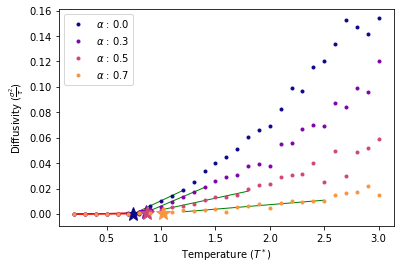

In [11]:
import matplotlib
#from common import *
%matplotlib inline
from piecewise.regressor import piecewise #https://www.datadoghq.com/blog/engineering/piecewise-regression/
from piecewise.plotter import plot_data_with_regression
#stop_after_percents = np.arange(10,105,15,dtype=float)
PROP_NAME ='bparticles'#'volume'#'pair_lj_energy','bond_harmonic_energy'#'potential_energy'
#plt.figure()
filter_saps=[0.0,30.,50.,70.]#,100.]#,100.]#[0.0,50.0,100.0]#,30,50,70]#,90]
colors = plt.cm.plasma(np.linspace(0,0.75,len(filter_saps)))
Tgs=[]
Tgs_tangent=[]
cure_percents = []
Cure_Ts=[]
markers=['+','.']
markersize=[10,10]
cooling_method='quench'

df_filtered=df[(df.quench_T<=3.0)&
               (df.quench_T>=0.1)&
               (df.CC_bond_angle!=109.5)&
               (df.cooling_method==cooling_method)]#(df.quench_T<=3.0)&(df.quench_T>=0.05)&
for i,sap in enumerate(filter_saps):
    cooling_colors = plt.cm.plasma(np.linspace(0,0.75,2))
    for j,(cooling_method,df_grp) in enumerate(df_filtered.groupby('cooling_method')):
        df_curing = df_grp[(df_grp.bond==False)&
                       (df_grp.calibrationT==305)&
                       (df_grp.cooling_method==cooling_method)&
                       (df_grp.stop_after_percent==sap)]
        cure_percent = df_curing.cure_percent.mean()
        cure_percents.append(cure_percent)
        Ts,Ds=getDiffusivities(project,df_curing,name=PROP_NAME)
        Cure_Ts.append(Ts)
        
        mul_fact=1000000
        #mul_fact=1
        Ds_scaled=Ds*mul_fact
        custom_ranges_l1, custom_ranges_l2 = get_custom_ranges(cooling_method)
        print(custom_ranges_l1[sap])
        Tg,Tg_prop,line_vals = Fit_Diffusivity1(Ts,
                                  Ds_scaled,
                                  method='use_viscous_region',
                                  min_D=0,
                                  ver=4,
                                  viscous_line_index=0,
                                  l1_T_bounds=custom_ranges_l1[sap],
                                  l2_T_bounds=custom_ranges_l2[sap])
        xs = Ts#np.linspace(0.1,4)
        plt.plot(Tg,
                 Tg_prop/mul_fact,
                 marker='*',
                 color=colors[i],
                 markersize=15)#,
                    
        plt.plot(Ts,
                 Ds,
                 marker='.',
                 color=colors[i],#cooling_colors[j],
                 linewidth=0.0,
                 label='$\\alpha$ : {:.1f}'.format(sap/100))

        
        #l_colors = plt.cm.coolwarm(np.linspace(0,0.75,len(line_vals)))
        l_colors=['r','g']
        for li,line_val in enumerate(line_vals):
            xs=line_val[0]
            ys=line_val[1]/mul_fact
            plt.plot(xs,
                     ys,
                     color=l_colors[li],
                     zorder=0,
                     linewidth=1)
        Tgs.append(Tg)
    #break
plt.legend(fontsize=10)
plt.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
Tgs = np.asarray(Tgs)
cure_percents = np.asarray(cure_percents)
data=[cure_percents,Tgs]
#plt.xlim(0.5,1.5)
#plt.ylim(-1e-4,5e-4)
plt.xlabel('Temperature ($T^*$)')
plt.ylabel('Diffusivity ($\\frac{\\sigma^2}{\\tau}$)')
#savefig(plt,'piecewise_regression_custom_range','all_alphas_zoomed.pdf')
#savefig(plt,'piecewise_regression_custom_range','all_alphas.pdf')
#np.savetxt('piecewise_regression_custom_range/Tg_{}.txt'.format(cooling_method),np.transpose(data))

plt.show()

[0.74333146 0.85964532 0.86702937 1.02171048]
[ 0.25 30.   50.   70.  ]
[0.74333146 0.85964532 0.86702937 1.02171048]
T1 1.2287017986737236 lambda 0.5
300 K in T*: 0.7679386241710773


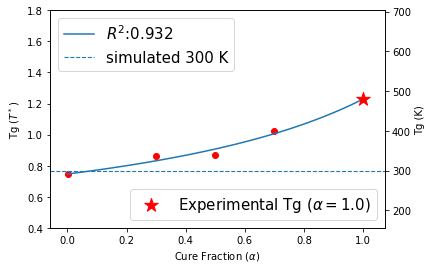

In [27]:
cure_percents = np.asarray(cure_percents)
#Tgs=[0.65,0.75,0.9,2.1]
fig, ax1 = plt.subplots()
ax2=ax1.twinx()
Tgs = np.asarray(Tgs)
Tgs_tangent = np.asarray(Tgs_tangent)
print(Tgs)
Tg_data = np.asarray([cure_percents/100.,Tgs])
cure_percents_ss = cure_percents#[:-1]
Tgs_ss = Tgs#[:-1]
print(cure_percents_ss)
print(Tgs_ss)
R2,fit_Tgs,T1,inter_parm,T0 = fit_Tg_to_DiBenedetto(cure_percents_ss/100.,
                                                 Tgs_ss,
                                                 T1=None,
                                                 T0=None)
print('T1',T1,'lambda',inter_parm)
alphas = np.linspace(0,1)
fit_ydata = DiBenedetto(alphas,T1,T0=T0,inter_param=inter_parm)
ax1.plot(alphas,fit_ydata,label='$R^2$:{}'.format(round(R2,3)))
ax1.scatter(cure_percents/100.,
            Tgs,
            color='r')

Tg_sim = T1#0.851796418313
Tg_exp = 480
roomT_exp = 300
Tex_toTsim = Tg_exp/Tg_sim
roomT_sim =  Tg_sim*roomT_exp/Tg_exp
Tg0_exp = Tg_exp*T0/Tg_sim
print('300 K in T*:',roomT_sim)
ax2.scatter(1.00,Tg_exp,marker='*',color='r',s=200,label='Experimental Tg ($\\alpha=1.0$)')
ax2.set_ylabel('Tg (K)')

sim_low_lim = 0.4
ex_low_lim = sim_low_lim*Tex_toTsim
sim_up_lim = 1.8
ex_up_lim = sim_up_lim*Tex_toTsim
ax2.set_ylim(ex_low_lim,ex_up_lim)
ax1.set_ylim(sim_low_lim,sim_up_lim)
#ax1.set_ylim(0,3)
show_roomT=True
if show_roomT:
    ax1.axhline(y=roomT_sim,linewidth=1.1,linestyle='--',label='simulated 300 K')
ax1.set_xlabel('Cure Fraction ($\\alpha$)')
ax1.set_ylabel('Tg ($T^*$)')
ax1.legend(fontsize=15,loc='upper left')
ax2.legend(fontsize=15,loc='lower right')
plt.ticklabel_format(axis='y',style='plain')
#savefig(plt,'piecewise_regression_custom_range','dibeneditto.pdf')

[0.74333146 0.85964532 0.86702937 1.02171048]
[ 0.25 30.   50.   70.  ]
[0.74333146 0.85964532 0.86702937 1.02171048]
T1 1.2287017975521861 lambda 0.5
300 K in T*: 0.7679386234701163


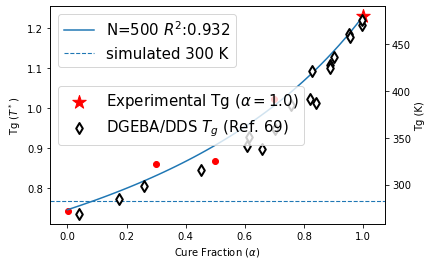

In [24]:
cure_percents = np.asarray(cure_percents)
#Tgs=[0.65,0.75,0.9,2.1]
fig, ax1 = plt.subplots()
ax2=ax1.twinx()
Tgs = np.asarray(Tgs)
Tgs_tangent = np.asarray(Tgs_tangent)
print(Tgs)
Tg_data = np.asarray([cure_percents/100.,Tgs])
cure_percents_ss = cure_percents#[:-1]
Tgs_ss = Tgs#[:-1]
print(cure_percents_ss)
print(Tgs_ss)
R2,fit_Tgs,T1,inter_parm,T0 = fit_Tg_to_DiBenedetto(cure_percents_ss/100.,
                                                 Tgs_ss,
                                                 T1=None,
                                                 T0=None)
print('T1',T1,'lambda',inter_parm)
alphas = np.linspace(0,1)
fit_ydata = DiBenedetto(alphas,T1,T0=T0,inter_param=inter_parm)
ax1.plot(alphas,fit_ydata,label='N=500 $R^2$:{}'.format(round(R2,3)))
ax1.scatter(cure_percents/100.,
            Tgs,
            color='r')

Tg_sim = T1#0.851796418313
Tg_exp = 480
roomT_exp = 300
Tex_toTsim = Tg_exp/Tg_sim
roomT_sim =  Tg_sim*roomT_exp/Tg_exp
Tg0_exp = Tg_exp*T0/Tg_sim
print('300 K in T*:',roomT_sim)
ax2.scatter(1.00,Tg_exp,marker='*',color='r',s=200,label='Experimental Tg ($\\alpha=1.0$)')
ax2.set_ylabel('Tg (K)')

sim_low_lim = 0.4
ex_low_lim = sim_low_lim*Tex_toTsim
sim_up_lim = 1.8
ex_up_lim = sim_up_lim*Tex_toTsim
#ax1.set_ylim(0,3)
show_roomT=True
if show_roomT:
    ax1.axhline(y=roomT_sim,linewidth=1.1,linestyle='--',label='simulated 300 K')
ax1.set_xlabel('Cure Fraction ($\\alpha$)')
ax1.set_ylabel('Tg ($T^*$)')

plt.ticklabel_format(axis='y',style='plain')
#savefig(plt,'piecewise_regression_custom_range','dibeneditto.pdf')

exp1_data = np.genfromtxt('Min1993.txt',delimiter=',')
#print(exp1_data)
ax2.scatter(exp1_data[:,0],
                exp1_data[:,1],
                marker='d',
                facecolor='w',
                linewidth=2,
                edgecolor='k',
                s=60,
                #label='$E_a$:{}'.format(activation_energy),
                color='k',
               zorder=1,
               label='DGEBA/DDS $T_g$ (Ref. 69)')

ax1.legend(fontsize=15,loc='upper left')
ax2.legend(fontsize=15,loc='center left')

In [1]:
import sys
sys.path.append("../")
from tg_analysis import get_tg_data

In [2]:
data_path_small = '/home/doryx/remote_data_kes/'
data_path_large = '/home/doryx/remote_data/'

alphas_S, fit_ydata_S, R2_S, cure_percents_S, Tgs_S = get_tg_data(data_path_small)
alphas_L, fit_ydata_L, R2_L, cure_percents_L, Tgs_L = get_tg_data(data_path_large)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
plt.scatter()